#### Сбор и обработка данных

In [1]:
# Создание датафрейма из названий файлов фотографий документов с указанием класса документа

import os
import pandas as pd

path = 'data/'
label = os.listdir(path)

df_list = []

for i in range(len(label)):
    img_names = os.listdir(path + label[i])
    df_list.append(pd.DataFrame({'img_names':img_names, 'labels':i}))

doc_text_df = pd.concat(df_list, axis=0)
doc_text_df['text'] = ''
doc_text_df.reset_index(drop=True, inplace=True)
doc_text_df

,img_names,labels,text
0,10352078_1_page002.jpg,0,
1,10352079_1_page002.jpg,0,
2,10357081_1_page002.jpg,0,
3,10370421_1_page002.jpg,0,
4,10390659_1_page002.jpg,0,
...,...,...,...
1361,11423772_1_page000.jpg,3,
1362,11425202_1_page000.jpg,3,
1363,11427853_2_page000.jpg,3,
1364,11441529_2_page000.jpg,3,


In [2]:
# заполнение столбца "text" текстовым содержанием документов

import json

# документы хранятся в json-файле в виде: имя файла фотографии: данные: {список слов текста документа}
with open('original_merged_data.json') as f:
    data_dict = json.load(f)
data_dict

for key in data_dict:
    text = ' '.join(data_dict[key]['data'])
    doc_text_df.loc[doc_text_df['img_names'] == key, ['text']] = text
doc_text_df = doc_text_df.loc[doc_text_df['text'] != '']
doc_text_df

,img_names,labels,text
0,10352078_1_page002.jpg,0,Акт Ng 9130 от 16 декабря 2021 Исполнитель Акц...
1,10352079_1_page002.jpg,0,Акт Ng 9135 от 16 декабря 2021 Исполнитель Акц...
2,10357081_1_page002.jpg,0,Акт Ng 9129 от 16 декабря 2021 Исполнитель Акц...
3,10370421_1_page002.jpg,0,Акт Ng 9129 от 16 декабря 2021 Исполнитель Акц...
4,10390659_1_page002.jpg,0,Акт Ng 9339 от 27 декабря 2021 Исполнитель Акц...
...,...,...,...
1361,11423772_1_page000.jpg,3,Универсальный Приложение Ng передаточный к пос...
1362,11425202_1_page000.jpg,3,Универсальный Приложение Ng передаточный к пос...
1363,11427853_2_page000.jpg,3,Универсальный Приложение Ng передаточный к пос...
1364,11441529_2_page000.jpg,3,Универсальный Приложение Ng передаточный к пос...


In [3]:
# столбец с названием файла фотографии документа теперь не нужен

doc_text_df.drop(columns=doc_text_df.columns[0], axis=1, inplace=True)
doc_text_df = doc_text_df.iloc[:, [1, 0]]
doc_text_df

C:\Users\21223242\AppData\Local\Temp\ipykernel_8072\4208167482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doc_text_df.drop(columns=doc_text_df.columns[0], axis=1, inplace=True)


,text,labels
0,Акт Ng 9130 от 16 декабря 2021 Исполнитель Акц...,0
1,Акт Ng 9135 от 16 декабря 2021 Исполнитель Акц...,0
2,Акт Ng 9129 от 16 декабря 2021 Исполнитель Акц...,0
3,Акт Ng 9129 от 16 декабря 2021 Исполнитель Акц...,0
4,Акт Ng 9339 от 27 декабря 2021 Исполнитель Акц...,0
...,...,...
1361,Универсальный Приложение Ng передаточный к пос...,3
1362,Универсальный Приложение Ng передаточный к пос...,3
1363,Универсальный Приложение Ng передаточный к пос...,3
1364,Универсальный Приложение Ng передаточный к пос...,3


#### Токенизация

 Максимальная длина:	 3675
 в среднем:	 1719
 медиана:	 1915
 75 процентиль:	 2112


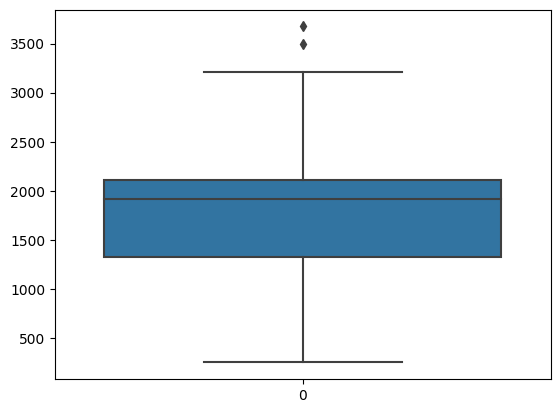

In [4]:
# Поиск максимальной длины текста

import numpy as np
import seaborn as sns

seq_of_lens = [len(i) for i in doc_text_df['text']]
max_seq_len = max(seq_of_lens)

mean_len = int(np.mean(seq_of_lens))
median_len = int(np.median(seq_of_lens))
third_quartile = int(np.percentile(seq_of_lens, 75))

sns.boxplot(seq_of_lens)
print(f' Максимальная длина:\t {max_seq_len}\n в среднем:\t {mean_len}\n медиана:\t {median_len}\n 75 процентиль:\t {third_quartile}')

In [5]:
# создание тренировочной и тестовой выборки

from sklearn.model_selection import train_test_split

docs_train, docs_valid = train_test_split(doc_text_df, test_size=0.2, random_state=1)

In [6]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification


checkpoint = 'rubert-tiny2'
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
tokenizer = BertTokenizer.from_pretrained(checkpoint)

labels_list = ['act', 'schet', 'sf', 'upd']
model.config.id2label = dict(enumerate(labels_list))
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

C:\Users\21223242\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Токенизация

from datasets import Dataset, DatasetDict, load_metric

docs_datasets = DatasetDict({
    'train': Dataset.from_pandas(docs_train, preserve_index=False),
    'valid': Dataset.from_pandas(docs_valid, preserve_index=False)
})


def tokenize_function(example):
    return tokenizer(example['text'], max_length=512, padding=True, truncation=True)

tokenized_datasets = docs_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map: 100%|██████████| 273/273 [00:01<00:00, 247.18 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1092
    })
    valid: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 273
    })
})

#### Обучение

In [8]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {'Accuracy': accuracy_score(labels, preds),
            'F1': f1_score(labels, preds, average="weighted")}

In [9]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = './the_result',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    evaluation_strategy = 'epoch',
    weight_decay=0.01,
    report_to=None,
    seed=11)


trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = tokenized_datasets['train'],
                  eval_dataset = tokenized_datasets['valid'],
                  compute_metrics = compute_metrics)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [11]:
trainer.evaluate()

100%|██████████| 35/35 [00:41<00:00,  1.19s/it]


{'eval_loss': 1.3847265243530273,
 'eval_Accuracy': 0.15384615384615385,
 'eval_F1': 0.10059660585976374,
 'eval_runtime': 42.883,
 'eval_samples_per_second': 6.366,
 'eval_steps_per_second': 0.816}

In [12]:
trainer.train()

                                                 
 25%|██▌       | 137/548 [08:26<19:18,  2.82s/it]

{'eval_loss': 0.4436957538127899, 'eval_Accuracy': 0.9304029304029304, 'eval_F1': 0.9023743428368199, 'eval_runtime': 41.2973, 'eval_samples_per_second': 6.611, 'eval_steps_per_second': 0.848, 'epoch': 1.0}


                                                   
 50%|█████     | 274/548 [16:52<13:12,  2.89s/it]

{'eval_loss': 0.2015438973903656, 'eval_Accuracy': 0.9523809523809523, 'eval_F1': 0.9418943725339141, 'eval_runtime': 41.5432, 'eval_samples_per_second': 6.571, 'eval_steps_per_second': 0.842, 'epoch': 2.0}


                                                   
 75%|███████▌  | 411/548 [25:14<06:40,  2.92s/it]

{'eval_loss': 0.13325189054012299, 'eval_Accuracy': 0.9743589743589743, 'eval_F1': 0.9723465280934745, 'eval_runtime': 41.8262, 'eval_samples_per_second': 6.527, 'eval_steps_per_second': 0.837, 'epoch': 3.0}


 91%|█████████ | 500/548 [30:14<02:42,  3.39s/it]

{'loss': 0.3951, 'learning_rate': 1.7518248175182485e-06, 'epoch': 3.65}


                                                 
100%|██████████| 548/548 [33:37<00:00,  3.68s/it]

{'eval_loss': 0.11893099546432495, 'eval_Accuracy': 0.9743589743589743, 'eval_F1': 0.9723465280934745, 'eval_runtime': 41.8347, 'eval_samples_per_second': 6.526, 'eval_steps_per_second': 0.837, 'epoch': 4.0}
{'train_runtime': 2017.6337, 'train_samples_per_second': 2.165, 'train_steps_per_second': 0.272, 'train_loss': 0.37113360853960914, 'epoch': 4.0}


TrainOutput(global_step=548, training_loss=0.37113360853960914, metrics={'train_runtime': 2017.6337, 'train_samples_per_second': 2.165, 'train_steps_per_second': 0.272, 'train_loss': 0.37113360853960914, 'epoch': 4.0})

#### Проверка

In [13]:
from transformers import pipeline

pipe = pipeline(model=model, tokenizer=tokenizer, task='text-classification')

In [14]:
from random import randint

start = len(tokenized_datasets['valid']) - 5

for i in range(5):
    txt = tokenized_datasets['valid']['text'][start + i]
    lb = tokenized_datasets['valid']['labels'][start + i]

    print(txt)
    print(f'Метка: {labels_list[lb]}')
    print(f'Предсказание модели: {pipe(txt)}\n\n')

Универсальный Приложение Ng передаточный к постановлению Правительства Российской Федерации документ Счет-фактура N БЦ210364699 от 22.11.2021 (1) от 26 декабря 2011 года Ng 1137 Статус 3 Исправление N от 1a) в ред Постановления Правительства РФ от 02.04.2021 Ng 534) 1 счет-фактура Продавец: ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ <О-Си-Эс-Центр> '2) и передаточный Адрес: 108811, Москва, Московский, 22 км Киевского шоссе, 6, 1, 7 (2a) документ (акт) 2 передаточный ИННМКПП продавца: 7701341820 / 997350001 (26) документ (акт) Грузоотправитель и его адрес: Он же '3) 3 счет-фактура Грузополучатель и его адрес: К платёжно-расчётному документу Ng 5) Документ об отгрузке Ng п/п '5а) Покупатель: ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО "СБЕРБАНК РОССИИ" (6) Адрес: 117312 МОСКВА Г, ВАВИЛОВА УЛ; 19 (ба) ИННКПП покупателя: 7707083893 773601001 (66) Валюта: наименование, код Российский рубль; 643 Идентификатор государственного контракта; договора (соглашения)(при наличии): '8 Информационное поле по документ